# Practica 2 - Ejercicio 3 - Clasificadores  y métricas de evaluación

- Ignacio David Vázquez Perez
- Seminario de Solución de Problemas de Inteligencia Artificial II

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.compose import make_column_selector
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from pipelinehelper import PipelineHelper
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import sys, os
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RepeatedKFold
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
import scikitplot as skplt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')
import warnings
warnings.simplefilter("ignore", category=ConvergenceWarning)
from sklearn.exceptions import ConvergenceWarning


In [14]:
import warnings
warnings.filterwarnings('ignore')

## Funciones

In [2]:
#Visualizar pca em 2D y 3D
class pca():
    def __init__(self,  df=None, titulo="Unspecified", label_y=None):
        self.df = df
        self.label_y = str(label_y)
        self.titulo = str(titulo)
        print(list(df))
        print(f"Numero de elementos de {label_y}\n", df[label_y].value_counts())
    def pca_2D(self):
        df_PCA = self.df.drop([self.label_y], axis=1)
        #instanciamos el metodo pca con 2 componentes
        pca = PCA(n_components=2)
        #encontramos los componentes principales usando 
        #el método de ajuste con 2 componentes
        #transformamos los datos scaled_data en 2 componentes con pca
        pca.fit(df_PCA)
        x_pca = pca.transform(df_PCA)
        ######
        #instanciamos un objeto para hacer PCA
        scaler = StandardScaler()
        #escalar los datos, estandarizarlos, para que cada
        #caracteristica tenga una varianza unitaria 
        scaler.fit(df_PCA)
        #aplicamos la reducción de rotación y dimensionalidad
        scaled_data = scaler.transform(df_PCA)
        pca = PCA().fit(scaled_data)
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance')
        plt.title('How many components are needed to describe the data.')
        ######
        print("Dimension de los features orginales: ", df_PCA.shape)
        print("Dimension de los features con 2 componentes", x_pca.shape)
        
        #visualizar los datos en 2 dimensiones
        #plt.figure(figsize=(8,6))
        fig, ax = plt.subplots()
        scatter = plt.scatter(x_pca[:,0],
                    x_pca[:,1],
                    c=self.df[self.label_y],
                    cmap='Set1',
                    marker='o',
                    s=4,
                    linewidths=0)
        #genera legend del target
        labels = np.unique(self.df[self.label_y])
        handles = [plt.Line2D([],[],marker=".", ls="", 
                              color=scatter.cmap(scatter.norm(yi))) for yi in labels]
        plt.legend(handles, labels)
        plt.xlabel('First principal component')
        plt.ylabel('Second Principal Component')
        plt.title(self.titulo)
        #plt.show()
        y = self.df[self.label_y]
        return x_pca, y
    def pca_3D(self):
        sns.set_style("white")  
        self.df[self.label_y] = pd.Categorical(self.df[self.label_y])
        my_color = self.df[self.label_y].cat.codes
        df_PCA = self.df.drop([self.label_y], axis=1)
        pca = PCA(n_components=3)
        pca.fit(df_PCA)
        result=pd.DataFrame(pca.transform(df_PCA), 
                            columns=['PCA%i' % i for i in range(3)], 
                            index=df_PCA.index)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scat = ax.scatter(result['PCA0'], 
                   result['PCA1'], 
                   result['PCA2'], 
                   c=my_color, 
                   cmap='Set1', 
                   s=4, marker="o",
                   linewidths=0)
        
        #genera legend del target
        labels = np.unique(self.df[self.label_y])
        handles = [plt.Line2D([],[],marker=".",ls="",
                                 color=scat.cmap(scat.norm(yi))) for yi in labels]               
        ax.legend(handles, labels)
        
        # make simple, bare axis lines through space:
        xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
        ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
        yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
        ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
        zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
        ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
         
        # label the axes
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title(self.titulo)
        #plt.show()
        fig.tight_layout()
        y = self.df[self.label_y]
        return result, y

In [57]:
def Gridsearchcv(X_train, X_test, y_train, y_test):
    ############
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', PipelineHelper([
            ('svc', SVC(probability=True)),
            ('lr', LogisticRegression()),
            ('kn', KNeighborsClassifier()),
            ('gnb', GaussianNB()),
            ('mlp', MLPClassifier(max_iter=500))
        ])),
    ])

    params = {
    'clf__selected_model': pipe.named_steps['clf'].generate({
        # mlp
        'mlp__hidden_layer_sizes': [(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,)],
        'mlp__activation': ['tanh', 'relu','identity', 'logistic'],
        'mlp__solver': ['sgd', 'adam','lbfgs'],
        'mlp__alpha': [0.0001, 0.05],
        'mlp__learning_rate': ['constant','adaptive'],

        # logistic regression
        'lr__penalty' : ['l2'],
        'lr__C' : np.logspace(-4, 4, 20),
        'lr__solver' : ['lbfgs','newton-cg','saga'],
        'lr__max_iter' : [100, 1000,2500, 5000],

        # KNeighborsClassifier
        'kn__n_neighbors' : [5,7,9,11,13,15],
        'kn__weights' : ['uniform','distance'],
        'kn__metric' : ['minkowski','euclidean','manhattan'],

        # naive bayes
        'gnb__var_smoothing': [np.logspace(0,-9, num=100)],

        # # #svm 
        'svc__C': [0.1, 0.5, 1, 10, 30, 40, 50, 75, 100, 500, 1000], 
        'svc__gamma' : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50],
        'svc__kernel': ['rbf'],
        
        }),
    }
    scoring = {
        'F1': make_scorer(f1_score, average='micro'),
        'pr': make_scorer(precision_score, average='micro'),
        'rc': make_scorer(recall_score, average='micro'),
        'acc': make_scorer(accuracy_score)

        # 'acc': 'accuracy',
        # 'pr': 'precision_micro',
        # 'F1' : 'f1_micro', 
        # 'rc': 'recall_micro'
        }
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
    #n_iter: 30,60, 100
    grid = RandomizedSearchCV(
        pipe, 
        params,
        refit = 'acc',
        cv = cv, 
        verbose = 1, 
        n_jobs=-1,
        n_iter = 100,
        scoring= scoring,
        return_train_score = True
        )

    grid.fit(X_train, y_train)
    df_grid=pd.DataFrame(grid.cv_results_)
    df_grid = df_grid.sort_values(by=['mean_test_F1'],ascending=False)
    df_grid = df_grid[[
        'param_clf__selected_model',
        'params',
        'mean_fit_time',
        'std_fit_time',

        'mean_test_pr',
        'std_test_pr',
        'rank_test_pr',
        
        'mean_test_rc',
        'std_test_rc',
        'rank_test_rc',
        
        'mean_test_F1', 
        'std_test_F1', 
        'rank_test_F1',
        
        'mean_test_acc', 
        'std_test_acc', 
        'rank_test_acc'
    ]]

    print("Best-Fit Parameters From Training Data:\n",grid.best_params_)
    grid_predictions = grid.best_estimator_.predict(X_test) 
    report = classification_report(y_test, grid_predictions, output_dict=True)
    report = pd.DataFrame(report).transpose()
    print(report)
    print(confusion_matrix(y_test, grid_predictions))

    return grid, df_grid, report

In [58]:
#Tune the Number of Selected Features
def RKFold(X,y):
    # define the evaluation method
    cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)
    # define the pipeline to evaluate
    model = LinearRegression()
    fs = SelectKBest(score_func=mutual_info_regression)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
    # define the grid
    grid = dict()
    grid['sel__k'] = [i for i in range(2, X.shape[1]+1)]
    # define the grid search
    search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
    # perform the search
    results = search.fit(X, y)
    # summarize best
    print('Best MAE: %.5f' % results.best_score_)
    print('Best Config: %s' % results.best_params_)
    # summarize all
    means = results.cv_results_['mean_test_score']
    params = results.cv_results_['params']
    for mean, param in zip(means, params):
        print(">%.5f with: %r" % (mean, param))
    return results.best_params_['sel__k']

_____________________________________

# Datasets

## Wine Quality Dataset

In [124]:
from sklearn.datasets import load_wine
df = load_wine()

In [125]:
df.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [126]:
df=pd.DataFrame(data=np.c_[df['data'],df['target']],columns=df['feature_names']+['target'])

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [128]:
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2.0


In [129]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [130]:
df.target=df.target.astype('int64').astype('category')
#Frequency
df['target'].value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline', 'target']
Numero de elementos de target
 1    71
0    59
2    48
Name: target, dtype: int64
Dimension de los features orginales:  (178, 13)
Dimension de los features con 2 componentes (178, 2)


(           PCA0       PCA1      PCA2
 0    318.562979  21.492131  3.130735
 1    303.097420  -5.364718  6.822835
 2    438.061133  -6.537309 -1.113223
 3    733.240139   0.192729 -0.917257
 4    -11.571428  18.489995 -0.554422
 ..          ...        ...       ...
 173   -6.980211  -4.541137 -2.474707
 174    3.131605   2.335191 -4.309931
 175   88.458074  18.776285 -2.237577
 176   93.456242  18.670819 -1.788392
 177 -186.943190  -0.213331 -5.630510
 
 [178 rows x 3 columns],
 0      0
 1      0
 2      0
 3      0
 4      0
       ..
 173    2
 174    2
 175    2
 176    2
 177    2
 Name: target, Length: 178, dtype: category
 Categories (3, int64): [0, 1, 2])

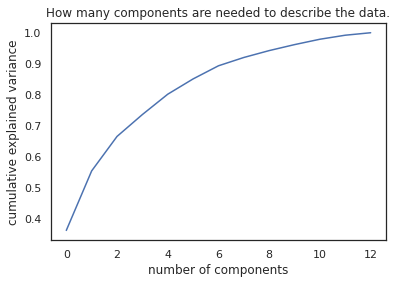

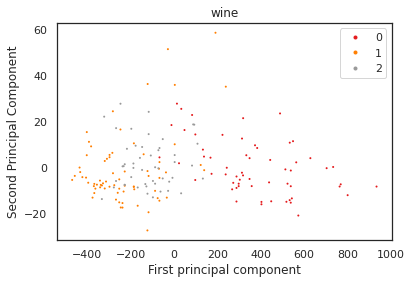

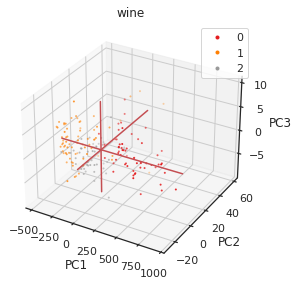

In [131]:
#visualizacion pca
cancer_pca = pca(df, titulo="wine", label_y='target')
cancer_pca.pca_2D(); cancer_pca.pca_3D()

In [132]:
best_params = RKFold(X,y)

Best MAE: -0.07509
Best Config: {'sel__k': 12}
>-0.15058 with: {'sel__k': 2}
>-0.11871 with: {'sel__k': 3}
>-0.09822 with: {'sel__k': 4}
>-0.08894 with: {'sel__k': 5}
>-0.08368 with: {'sel__k': 6}
>-0.08134 with: {'sel__k': 7}
>-0.07914 with: {'sel__k': 8}
>-0.08055 with: {'sel__k': 9}
>-0.07631 with: {'sel__k': 10}
>-0.07544 with: {'sel__k': 11}
>-0.07509 with: {'sel__k': 12}
>-0.07523 with: {'sel__k': 13}


In [133]:
import warnings
warnings.filterwarnings('ignore')

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y, shuffle=True)
grid, df_grid, grid_report= Gridsearchcv(X_train, X_test, y_train, y_test)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-pac

Best-Fit Parameters From Training Data:
 {'clf__selected_model': ('mlp', {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'lbfgs'})}
              precision    recall  f1-score    support
0.0            1.000000  0.916667  0.956522  12.000000
1.0            0.933333  1.000000  0.965517  14.000000
2.0            1.000000  1.000000  1.000000  10.000000
accuracy       0.972222  0.972222  0.972222   0.972222
macro avg      0.977778  0.972222  0.974013  36.000000
weighted avg   0.974074  0.972222  0.972097  36.000000
[[11  1  0]
 [ 0 14  0]
 [ 0  0 10]]


/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


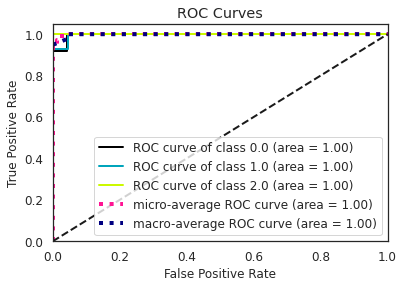

In [145]:
y_pred = grid.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred)
plt.show()

In [143]:
df_grid[:10]

,param_clf__selected_model,params,mean_fit_time,std_fit_time,mean_test_pr,std_test_pr,rank_test_pr,mean_test_rc,std_test_rc,rank_test_rc,mean_test_F1,std_test_F1,rank_test_F1,mean_test_acc,std_test_acc,rank_test_acc
85,"(mlp, {'activation': 'identity', 'alpha': 0.00...","{'clf__selected_model': ('mlp', {'activation':...",0.031918,0.012147,0.983580,0.017559,1,0.983580,0.017559,1,0.983580,0.017559,1,0.983580,0.017559,1
39,"(mlp, {'activation': 'identity', 'alpha': 0.00...","{'clf__selected_model': ('mlp', {'activation':...",0.016220,0.002393,0.981281,0.017516,2,0.981281,0.017516,2,0.981281,0.017516,2,0.981281,0.017516,2
27,"(lr, {'C': 0.23357214690901212, 'max_iter': 25...","{'clf__selected_model': ('lr', {'C': 0.2335721...",0.016314,0.002009,0.981117,0.021960,3,0.981117,0.021960,3,0.981117,0.021960,3,0.981117,0.021960,3
73,"(lr, {'C': 0.23357214690901212, 'max_iter': 10...","{'clf__selected_model': ('lr', {'C': 0.2335721...",0.019163,0.005014,0.981117,0.021960,3,0.981117,0.021960,3,0.981117,0.021960,3,0.981117,0.021960,3
17,"(mlp, {'activation': 'identity', 'alpha': 0.00...","{'clf__selected_model': ('mlp', {'activation':...",0.311272,0.030201,0.978900,0.028003,5,0.978900,0.028003,5,0.978900,0.028003,5,0.978900,0.028003,5
99,"(lr, {'C': 1438.44988828766, 'max_iter': 2500,...","{'clf__selected_model': ('lr', {'C': 1438.4498...",0.028734,0.006219,0.978818,0.021666,6,0.978818,0.021666,6,0.978818,0.021666,6,0.978818,0.021666,6
83,"(mlp, {'activation': 'identity', 'alpha': 0.00...","{'clf__selected_model': ('mlp', {'activation':...",0.025937,0.008093,0.978818,0.025288,6,0.978818,0.025288,6,0.978818,0.025288,6,0.978818,0.025288,6
53,"(mlp, {'activation': 'identity', 'alpha': 0.00...","{'clf__selected_model': ('mlp', {'activation':...",0.023275,0.003428,0.978818,0.025288,6,0.978818,0.025288,6,0.978818,0.025288,6,0.978818,0.025288,6
40,"(lr, {'C': 3792.690190732246, 'max_iter': 100,...","{'clf__selected_model': ('lr', {'C': 3792.6901...",0.019615,0.003300,0.978818,0.021666,6,0.978818,0.021666,6,0.978818,0.021666,6,0.978818,0.021666,6
61,"(lr, {'C': 78.47599703514607, 'max_iter': 1000...","{'clf__selected_model': ('lr', {'C': 78.475997...",0.031164,0.006537,0.978818,0.021666,6,0.978818,0.021666,6,0.978818,0.021666,6,0.978818,0.021666,6


In [144]:
df_grid.iloc[1].transpose()[0]

('mlp',
 {'activation': 'identity',
  'alpha': 0.0001,
  'hidden_layer_sizes': (7,),
  'learning_rate': 'constant',
  'solver': 'lbfgs'})

In [147]:
df_grid.iloc[2].transpose()[0]

('lr',
 {'C': 0.23357214690901212,
  'max_iter': 2500,
  'penalty': 'l2',
  'solver': 'newton-cg'})

## Diabetes dataset

In [155]:
df = pd.read_csv("diabates_dataset.csv",header=None)

In [156]:
df

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       768 non-null    int64  
 1   1       768 non-null    int64  
 2   2       768 non-null    int64  
 3   3       768 non-null    int64  
 4   4       768 non-null    int64  
 5   5       768 non-null    float64
 6   6       768 non-null    float64
 7   7       768 non-null    int64  
 8   8       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [158]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [159]:
#Frequency
df.iloc[:,-1].value_counts()

0    500
1    268
Name: 8, dtype: int64

In [164]:
df.columns = df.columns.map(str)

In [165]:
df

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


['0', '1', '2', '3', '4', '5', '6', '7', '8']
Numero de elementos de 8
 0    500
1    268
Name: 8, dtype: int64
Dimension de los features orginales:  (768, 8)
Dimension de los features con 2 componentes (768, 2)


(          PCA0       PCA1       PCA2
 0   -75.714655 -35.950783  -7.260789
 1   -82.358268  28.908213  -5.496671
 2   -74.630643 -67.906496  19.461808
 3    11.077423  34.898486  -0.053018
 4    89.743788  -2.746937  25.212859
 ..         ...        ...        ...
 763  99.237881  25.080927 -19.534825
 764 -78.641239  -7.688010  -4.137227
 765  32.113198   3.376665  -1.587864
 766 -80.214494 -14.186020  12.351264
 767 -81.308150  21.621496  -8.152768
 
 [768 rows x 3 columns],
 0      1
 1      0
 2      1
 3      0
 4      1
       ..
 763    0
 764    0
 765    0
 766    1
 767    0
 Name: 8, Length: 768, dtype: category
 Categories (2, int64): [0, 1])

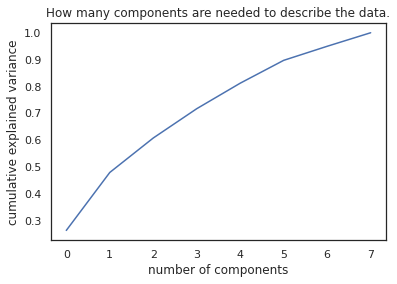

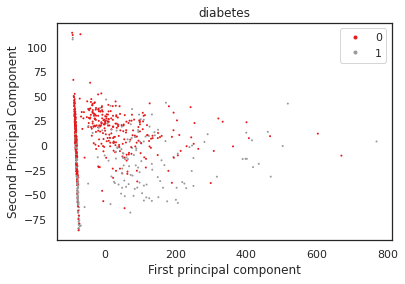

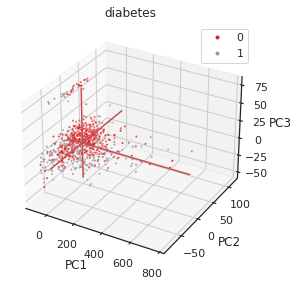

In [166]:
#visualizacion pca
diabetes_pca = pca(df, titulo="diabetes", label_y='8')
diabetes_pca.pca_2D(); diabetes_pca.pca_3D()

In [167]:
best_params = RKFold(X,y)

Best MAE: -0.16490
Best Config: {'sel__k': 8}
>-0.17290 with: {'sel__k': 2}
>-0.16914 with: {'sel__k': 3}
>-0.16896 with: {'sel__k': 4}
>-0.16747 with: {'sel__k': 5}
>-0.16626 with: {'sel__k': 6}
>-0.16539 with: {'sel__k': 7}
>-0.16490 with: {'sel__k': 8}


In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y, shuffle=True)
grid, df_grid, grid_report= Gridsearchcv(X_train, X_test, y_train, y_test)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-pac

Best-Fit Parameters From Training Data:
 {'clf__selected_model': ('svc', {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'})}
              precision    recall  f1-score     support
0              0.770642  0.840000  0.803828  100.000000
1              0.644444  0.537037  0.585859   54.000000
accuracy       0.733766  0.733766  0.733766    0.733766
macro avg      0.707543  0.688519  0.694843  154.000000
weighted avg   0.726391  0.733766  0.727397  154.000000
[[84 16]
 [25 29]]


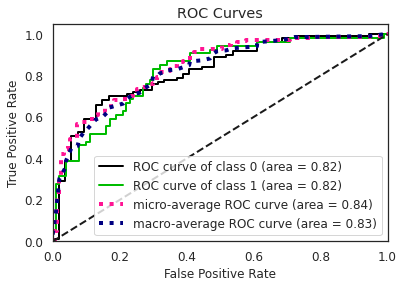

In [171]:
y_pred = grid.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred)
plt.show()

In [170]:
df_grid.iloc[:10]

,param_clf__selected_model,params,mean_fit_time,std_fit_time,mean_test_pr,std_test_pr,rank_test_pr,mean_test_rc,std_test_rc,rank_test_rc,mean_test_F1,std_test_F1,rank_test_F1,mean_test_acc,std_test_acc,rank_test_acc
26,"(svc, {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'})","{'clf__selected_model': ('svc', {'C': 10, 'gam...",0.134583,0.020136,0.777924,0.021699,1,0.777924,0.021699,1,0.777924,0.021699,1,0.777924,0.021699,1
66,"(mlp, {'activation': 'logistic', 'alpha': 0.00...","{'clf__selected_model': ('mlp', {'activation':...",1.215981,0.157352,0.776863,0.020895,2,0.776863,0.020895,2,0.776863,0.020895,2,0.776863,0.020895,2
62,"(lr, {'C': 0.08858667904100823, 'max_iter': 10...","{'clf__selected_model': ('lr', {'C': 0.0885866...",0.018196,0.002442,0.776298,0.020269,3,0.776298,0.020269,3,0.776298,0.020269,3,0.776298,0.020269,3
99,"(lr, {'C': 1438.44988828766, 'max_iter': 2500,...","{'clf__selected_model': ('lr', {'C': 1438.4498...",0.018255,0.001067,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4
90,"(lr, {'C': 1438.44988828766, 'max_iter': 5000,...","{'clf__selected_model': ('lr', {'C': 1438.4498...",0.014669,0.002875,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4
31,"(mlp, {'activation': 'identity', 'alpha': 0.05...","{'clf__selected_model': ('mlp', {'activation':...",0.029348,0.011731,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4
69,"(lr, {'C': 545.5594781168514, 'max_iter': 2500...","{'clf__selected_model': ('lr', {'C': 545.55947...",0.015811,0.003913,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4
71,"(lr, {'C': 206.913808111479, 'max_iter': 1000,...","{'clf__selected_model': ('lr', {'C': 206.91380...",0.020176,0.002984,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4
73,"(lr, {'C': 206.913808111479, 'max_iter': 100, ...","{'clf__selected_model': ('lr', {'C': 206.91380...",0.012100,0.001929,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4
21,"(lr, {'C': 29.763514416313132, 'max_iter': 500...","{'clf__selected_model': ('lr', {'C': 29.763514...",0.016512,0.005240,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4,0.776294,0.022613,4


In [122]:
df_grid.iloc[2].transpose()

param_clf__selected_model    (svc, {'C': 1000, 'gamma': 0.0001, 'kernel': '...
params                       {'clf__selected_model': ('svc', {'C': 1000, 'g...
mean_fit_time                                                         0.089561
std_fit_time                                                          0.006516
mean_test_pr                                                          0.777613
std_test_pr                                                           0.016164
rank_test_pr                                                                 3
mean_test_rc                                                          0.777613
std_test_rc                                                           0.016164
rank_test_rc                                                                 3
mean_test_F1                                                          0.777613
std_test_F1                                                           0.016164
rank_test_F1                                        

In [117]:
df_grid.iloc[2].param_clf__selected_model

('svc', {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'})

## Auto_Insurance_Sweden dataset

In [82]:
df = pd.read_csv('Auto_Insurance_Sweden.csv')

In [83]:
df

,X,Y
0,108,392.5
1,19,46.2
2,13,15.7
3,124,422.2
4,40,119.4
...,...,...
58,9,87.4
59,31,209.8
60,14,95.5
61,53,244.6


In [84]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [85]:
from sklearn import linear_model
from sklearn import svm

In [86]:
classifiers = [
    svm.SVR(),
    linear_model.Ridge(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.LassoCV(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression()
    ]

In [87]:
dict_list = ['name', 'y_pred', 'mae', 'model']
class_dict = {}
class_list = []

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [89]:
for i, classifier in enumerate(classifiers):
    class_dict = {}
    class_dict[dict_list[0]] = (classifiers[i].__class__.__name__)
    clf = classifier
    pipeline = Pipeline(steps=[
    #('scaler', MinMaxScaler()),
    #('scaler', RobustScaler()),
    ('scaler', StandardScaler()),
    ('model', clf)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    #pipeline.fit(X_train, y_train)
    #y_pred = pipeline.predict(X_test)

    class_dict[dict_list[1]] = y_pred
    mae = metrics.mean_absolute_error(y_test, y_pred)
    class_dict[dict_list[2]] = mae
    class_dict[dict_list[3]] = clf
    class_list.append(class_dict)

In [92]:
minl = []
for dicts in class_list:
    print(dicts['name'],':',dicts['mae'])
    minl.append(dicts['mae'])

min_mae = min(minl)

def return_best_mae(class_list, min_mae):
    for dicts in class_list:
        if dicts['mae'] == min_mae:
            return dicts

best_mae = return_best_mae(class_list, min_mae)
print(best_mae)
#with best model do a hiperparameter tuning

SVR : 73.78140945808983
Ridge : 25.193273790732583
SGDRegressor : 25.51748998770079
BayesianRidge : 25.45977295234626
LassoLars : 24.164314475436154
LassoCV : 24.31363833522666
ARDRegression : 25.45977295234625
PassiveAggressiveRegressor : 26.214192356934724
TheilSenRegressor : 27.337438810057126
LinearRegression : 25.583738305456325
{'name': 'LassoLars', 'y_pred': array([117.71256941,  76.28586091,  66.72585126,  89.03254045,
       194.19264662,  66.72585126,  53.97917172, 155.95260801,
       216.49933581, 200.56598639,  38.0458223 ,  73.09919103,
        60.35251149,  38.0458223 , 120.89923929,  50.79250184,
       420.44620839,  66.72585126, 219.68600569,  41.23249219,
       117.71256941]), 'mae': 24.164314475436154, 'model': LassoLars()}


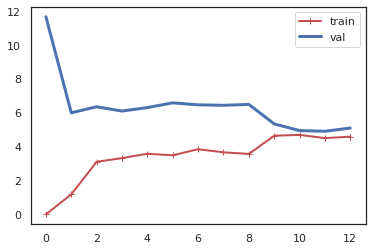

In [93]:
#learning curve
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=1)

    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns = X.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val),columns = X.columns)

    train_errors, val_errors = [], []
    for m in range(1, len(X_train_scaled)):
        model.fit(X_train_scaled[:m], y_train[:m])
        y_train_predict = model.predict(X_train_scaled[:m])
        y_val_predict = model.predict(X_val_scaled)
        train_errors.append(metrics.mean_absolute_error(y_train[:m], y_train_predict))
        val_errors.append(metrics.mean_absolute_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()

plot_learning_curves(model = best_mae['model'], X = X_test, y = y_test)

Text(0.5, 0, 'Errors')

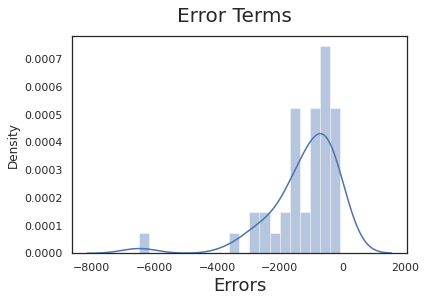

In [94]:
#Residual Analysis

y_train_price = best_mae['model'].predict(X_train)
#y_train_price = best_mae['model'].predict(X_train)

#plot
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)        
plt.xlabel('Errors', fontsize = 18)    

No handles with labels found to put in legend.


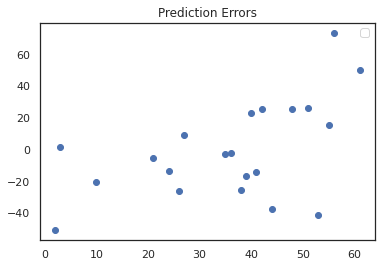

In [95]:
plt.plot(y_test - best_mae['y_pred'],marker='o',linestyle='')
plt.title("Prediction Errors")
plt.legend()